# COVID-19 Data Analysis and Forecasting

#### Author: Joseph Denney
#### Email: joseph.d.denney@gmail.com
#### github: www.github.com/josephdenney/Covid_Analysis

## Introduction

### Problem and Purpose

#### This project will use forecasting to model Covid-19 deaths  based on current hospitalization, ventilator, and death data. I will be using API html links to bring in up to date data regularly. This project will use supervised learning in the form of ARIMA and SARIMAX in order to create time series death forecasts.

#### The purpose of this analysis is to provide an accurate forecast of Covid-19 related deaths as 2021 progresses.
#### Our challenges are -
#### * 1. Create multiple forecasts by creating forecasts for specific states
#### * 2. Build a forecast for the United States as a whole
#### * 3. Provide insights as to the urgency of making changes to how we are operating as a country

## Table of Contents

### Standard Libraries

In [1]:
from tensorflow.random import set_seed
import numpy as np

set_seed(42)
np.random.seed(42) 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib
%matplotlib inline
import functools
from jupyter_plotly_dash import JupyterDash
import datetime as dt
from datetime import date
from datetime import datetime, timedelta
import pandas_datareader as pdr
import holidays

In [3]:
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import mse,rmse
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.ar_model import AR, ARResults
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, TensorBoard

In [4]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import statsmodels.api as sm
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

In [5]:
scaler = MinMaxScaler()
standard_scaler = StandardScaler()

### Custom Libraries

In [177]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from Cust_Func import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Explore Data

### Create New DataFrame

In [7]:
open_links = False

In [8]:
import webbrowser

if open_links == True:
    webbrowser.open("https://covidtracking.com/")
    webbrowser.open("https://covidtracking.com/data/api")

#### The Covid Tracking Project was organized by the news agency The Atlantic early in 2020 in an effort to provide as much data on the pandemic as possible. Coordination of state by state Covid data required building working relationships with state officials to obtain relevant state information. Above are links to the project that can provide further information regarding Covid-19. Additionally, it is worth noting that the project is coming to its end at the beginning of March 2021 as a result of improvements to Federal collection of data. 

In [9]:
# set to true to fetch new data
get_data = False

In [10]:
if get_data == True:
    df_states = pd.read_csv('https://api.covidtracking.com/v1/states/daily.csv',index_col='date',parse_dates=True)
    df_whole_US = pd.read_csv('https://api.covidtracking.com/v1/us/daily.csv',index_col='date',parse_dates=True)
    df_states.to_csv('StateData.csv')
    df_whole_US.to_csv('USA.csv')
else:
    df_states = pd.read_csv('StateData.csv', index_col='date', parse_dates=True)
    df_whole_US = pd.read_csv('USA.csv', index_col='date', parse_dates=True)

In [11]:
df_states.head()

,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,
2021-02-10,AK,53991.0,NaN,NaN,NaN,totalTestsViral,1568003.0,34.0,1224.0,NaN,...,53991,0,1,baf68d880d4bd467802c16dcd7b66d8a228e6137,0,0,0,0,0,NaN
2021-02-10,AL,476067.0,102466.0,1830673.0,NaN,totalTestsPeopleViral,2204274.0,1401.0,43685.0,NaN,...,2306740,309,186,0daf535b515ad0db70e0dd283dbc5b236218df21,0,0,0,0,0,NaN
2021-02-10,AR,309940.0,64075.0,2306389.0,NaN,totalTestsViral,2552254.0,735.0,14211.0,283.0,...,2616329,26,37,7bc38ff5f537b736cba8b490100e49387dc29045,0,0,0,0,0,NaN
2021-02-10,AS,0.0,NaN,2140.0,NaN,totalTestsViral,2140.0,NaN,NaN,NaN,...,2140,0,0,f2b562c1317d5a2b5e6b546f5e8d12a1937bcf8f,0,0,0,0,0,NaN
2021-02-10,AZ,789245.0,52525.0,2841495.0,NaN,totalTestsViral,7061776.0,2589.0,55088.0,763.0,...,3630740,176,121,94f1c11ee26d099f1b29e910fc17ec21627f0331,0,0,0,0,0,NaN


In [12]:
df_states.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19373 entries, 2021-02-10 to 2020-01-13
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   state                        19373 non-null  object 
 1   positive                     19184 non-null  float64
 2   probableCases                8318 non-null   float64
 3   negative                     15424 non-null  float64
 4   pending                      2014 non-null   float64
 5   totalTestResultsSource       19373 non-null  object 
 6   totalTestResults             19271 non-null  float64
 7   hospitalizedCurrently        16013 non-null  float64
 8   hospitalizedCumulative       11941 non-null  float64
 9   inIcuCurrently               10484 non-null  float64
 10  inIcuCumulative              3492 non-null   float64
 11  onVentilatorCurrently        8322 non-null   float64
 12  onVentilatorCumulative       1193 non-null   float64
 13 

In [13]:
df_whole_US.head()

,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,...,lastModified,recovered,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,hash
date,,,,,,,,,,,,,,,,,,,,,
2021-02-10,56,27063243.0,125730666.0,12079.0,76979.0,834314.0,15788.0,43184.0,5121.0,4106.0,...,2021-02-10T24:00:00Z,NaN,0,0,3445,3226,406559,95194,1393156,9617441c49c13397399e16c97af8d2802228c1db
2021-02-09,56,26968049.0,125324107.0,10516.0,79179.0,831088.0,16129.0,43000.0,5216.0,4092.0,...,2021-02-09T24:00:00Z,NaN,0,0,2795,3144,544215,92986,1502502,1171d1f4d19e38fe981fe4ea36702d977051a9ba
2021-02-08,56,26875063.0,124779892.0,12114.0,80055.0,827944.0,16174.0,42833.0,5260.0,4080.0,...,2021-02-08T24:00:00Z,NaN,0,0,1309,1638,4866739,77737,1434298,fe5eb3c282fee2b8fa0cacce8bc9497711b286db
2021-02-07,56,26797326.0,119913153.0,12061.0,81439.0,826306.0,16616.0,42779.0,5342.0,4079.0,...,2021-02-07T24:00:00Z,NaN,0,0,1475,1543,393480,95994,1498467,652854f6dbc5adcea89dd9eb3338eba0c155b458
2021-02-06,56,26701332.0,119519673.0,12070.0,84233.0,824763.0,17093.0,42730.0,5475.0,4078.0,...,2021-02-06T24:00:00Z,NaN,0,0,2994,2443,518729,114557,1881694,049e3795a89dd7b777094aaecc923ed916ea3aee


### Plot of Ventilators and Deaths for Each State

In [14]:
df_states.columns.unique

<bound method Index.unique of Index(['state', 'positive', 'probableCases', 'negative', 'pending',
       'totalTestResultsSource', 'totalTestResults', 'hospitalizedCurrently',
       'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
       'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered',
       'dataQualityGrade', 'lastUpdateEt', 'dateModified', 'checkTimeEt',
       'death', 'hospitalized', 'dateChecked', 'totalTestsViral',
       'positiveTestsViral', 'negativeTestsViral', 'positiveCasesViral',
       'deathConfirmed', 'deathProbable', 'totalTestEncountersViral',
       'totalTestsPeopleViral', 'totalTestsAntibody', 'positiveTestsAntibody',
       'negativeTestsAntibody', 'totalTestsPeopleAntibody',
       'positiveTestsPeopleAntibody', 'negativeTestsPeopleAntibody',
       'totalTestsPeopleAntigen', 'positiveTestsPeopleAntigen',
       'totalTestsAntigen', 'positiveTestsAntigen', 'fips', 'positiveIncrease',
       'negativeIncrease', 'total', 'totalTestRe

In [15]:
df_states.isnull().sum()

state                              0
positive                         189
probableCases                  11055
negative                        3949
pending                        17359
totalTestResultsSource             0
totalTestResults                 102
hospitalizedCurrently           3360
hospitalizedCumulative          7432
inIcuCurrently                  8889
inIcuCumulative                15881
onVentilatorCurrently          11051
onVentilatorCumulative         18180
recovered                       5469
dataQualityGrade                1335
lastUpdateEt                     584
dateModified                     584
checkTimeEt                      584
death                            871
hospitalized                    7432
dateChecked                      584
totalTestsViral                 6546
positiveTestsViral             11923
negativeTestsViral             14909
positiveCasesViral              5786
deathConfirmed                 10356
deathProbable                  12475
t

In [16]:
# columns to keep in dataframe
columns = ['state','death','inIcuCurrently','onVentilatorCurrently','positive','hospitalizedCurrently','deathIncrease']

In [17]:
for col in columns:
    df_states[col] = df_states[col].fillna(0)

In [18]:
df_states = sort_and_clean_df(dataframe=df_states, target_columns=columns, percent_data_threshold=.05)

In [19]:
df_states.iloc[:50].sort_values(by='death',ascending=False) # only graph the top 7 
# that keep state ventilator data

,state,death,inIcuCurrently,onVentilatorCurrently,positive,hospitalizedCurrently,deathIncrease
date,,,,,,,
2021-02-10,CA,44995.0,3127.0,0.0,3362981.0,11516.0,518
2021-02-10,TX,39386.0,2740.0,0.0,2517453.0,9165.0,385
2021-02-10,NY,36619.0,1423.0,955.0,1494187.0,7593.0,138
2021-02-10,FL,28691.0,0.0,0.0,1765659.0,5129.0,165
2021-02-10,PA,22745.0,569.0,293.0,880291.0,2789.0,125
2021-02-10,NJ,22250.0,533.0,341.0,732674.0,2786.0,147
2021-02-10,IL,21869.0,464.0,232.0,1152995.0,2082.0,67
2021-02-10,MI,15939.0,299.0,149.0,624970.0,1175.0,14
2021-02-10,GA,15421.0,0.0,0.0,950906.0,3617.0,120


In [20]:
df_states['state'].unique() # list of states to iterate through

array(['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
       'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV',
       'WY'], dtype=object)

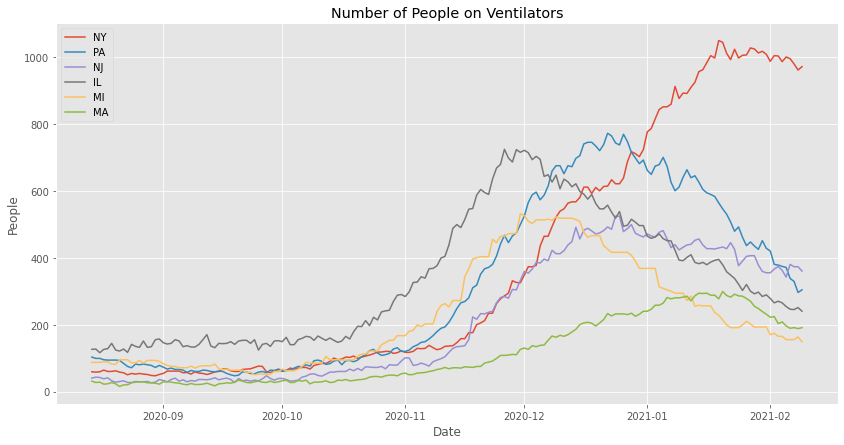

In [21]:
# for loop iterates through shortened list and prints ventilator usage
# for the trailing 180 day period. 
state_postal = ['NY', 'PA', 'NJ','IL','MI','MA']

fig = plt.figure(figsize=(14,7));

for state in state_postal:
    df_individual = df_states[df_states['state']==state]['onVentilatorCurrently'].sort_index()
    df_plot = df_individual.iloc[(df_individual.index.argmax()-180):(df_individual.index.argmax())]
    plt.plot(df_plot,label=f'{state}');
    plt.title('Number of People on Ventilators')
    plt.xlabel('Date')
    plt.ylabel('People')
    plt.legend();

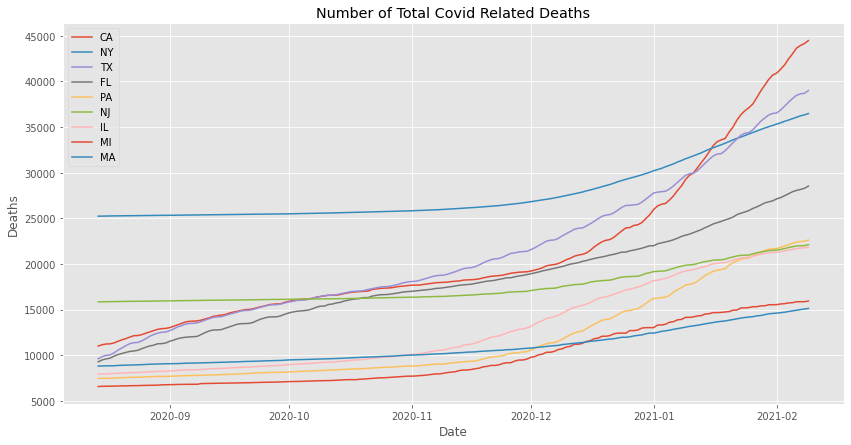

In [22]:
# same as above graph - all states have death data, this is a graph of the
# states with the highest covid mortality 
state_postal = ['CA', 'NY', 'TX', 'FL', 'PA', 'NJ','IL','MI','MA'] # highest death count states
# some do not have ventilator data reported. 

fig = plt.figure(figsize=(14,7));

for state in state_postal:
    df_individual = df_states[df_states['state']==state].death.sort_index()
    df_plot = df_individual.iloc[(df_individual.index.argmax()-180):(df_individual.index.argmax())]
    plt.plot(df_plot,label=f'{state}');
    plt.title('Number of Total Covid Related Deaths')
    plt.xlabel('Date')
    plt.ylabel('Deaths')
    plt.legend();

### Plot Alaska Death Count

In [23]:
df_AK = df_states[df_states['state']=='AK'] # just look at Alaska for now 

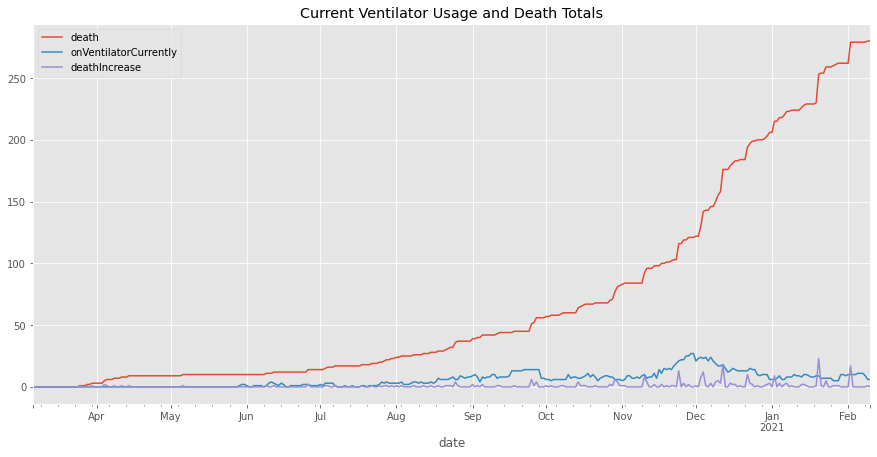

In [24]:
fig = plt.figure(figsize=(15,7));

df_AK['death'].plot(legend=True,title='Current Ventilator Usage and Death Totals');
df_AK['onVentilatorCurrently'].plot(legend=True);
df_AK['deathIncrease'].plot(legend=True);

Ventilator usage in Alaska peaks right before the end of December. deathIncrease is the rate of death, or 'volume' of death. Spikes in that line correspond to a steeper increase in deaths along the red trend. 

# Modeling and Forecasts

### Alaska SARIMA Model - Initial Modeling

In [25]:
df_AK = df_AK.sort_index()

In [26]:
df_AK = df_AK.dropna(subset=['death'])
df_AK = df_AK.dropna(subset=['onVentilatorCurrently'])

In [27]:
df_alaska = pd.DataFrame(df_AK)

In [28]:
print(df_alaska.index.min())
print(df_alaska.index.max())
print('Length of dataframe: ' , len(df_alaska))

2020-03-06 00:00:00
2021-02-10 00:00:00
Length of dataframe:  342


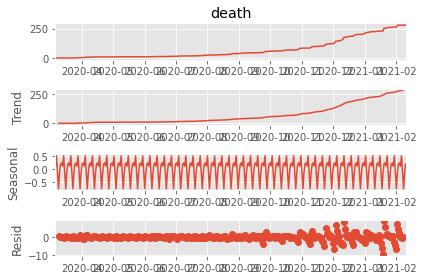

In [29]:
sd(df_alaska['death'], model='additive').plot(); # alaska = seasonal

In [30]:
stepwise_fit = auto_arima(df_alaska['death'],start_p=0,start_q=0,max_p=10,
                          max_q=10, seasonal=True, seasonal_test='ocsb', maxiter=75, method='lbfgs',
                          n_jobs=-1,stepwise=True)

In [31]:
model = SARIMAX(df_alaska['death'], order=stepwise_fit.order,seasonal_order=stepwise_fit.seasonal_order).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  death   No. Observations:                  342
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -767.776
Date:                Thu, 11 Feb 2021   AIC                           1539.553
Time:                        11:15:11   BIC                           1547.211
Sample:                    03-06-2020   HQIC                          1542.604
                         - 02-10-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9663      0.010    -94.016      0.000      -0.986      -0.946
sigma2         5.3147      0.096     55.223      0.000       5.126       5.503
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):             19498.25
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):             102.34   Skew:                             5.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
# dont forget get_predict
predictions_AK = model.get_forecast(30)

In [33]:
predictions_AK.predicted_mean

2021-02-11    281.766482
2021-02-12    283.532965
2021-02-13    285.299447
2021-02-14    287.065929
2021-02-15    288.832411
2021-02-16    290.598894
2021-02-17    292.365376
2021-02-18    294.131858
2021-02-19    295.898341
2021-02-20    297.664823
2021-02-21    299.431305
2021-02-22    301.197788
2021-02-23    302.964270
2021-02-24    304.730752
2021-02-25    306.497234
2021-02-26    308.263717
2021-02-27    310.030199
2021-02-28    311.796681
2021-03-01    313.563164
2021-03-02    315.329646
2021-03-03    317.096128
2021-03-04    318.862611
2021-03-05    320.629093
2021-03-06    322.395575
2021-03-07    324.162057
2021-03-08    325.928540
2021-03-09    327.695022
2021-03-10    329.461504
2021-03-11    331.227987
2021-03-12    332.994469
Freq: D, Name: predicted_mean, dtype: float64

In [34]:
predictions_AK.predicted_mean
predictions_AK.conf_int(alpha=.05) 

,lower death,upper death
2021-02-11,277.248067,286.284897
2021-02-12,277.034321,290.031608
2021-02-13,277.206530,293.392364
2021-02-14,277.565859,296.565999
2021-02-15,278.036723,299.628100
2021-02-16,278.581057,302.616731
2021-02-17,279.176657,305.554095
2021-02-18,279.809321,308.454396
2021-02-19,280.469371,311.327310
2021-02-20,281.149895,314.179751


In [35]:
stepwise_fit.order

(0, 2, 1)

In [36]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  342
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -766.413
Date:                Thu, 11 Feb 2021   AIC                           1538.826
Time:                        11:15:12   BIC                           1550.313
Sample:                             0   HQIC                          1543.403
                                - 342                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0068      0.004      1.873      0.061      -0.000       0.014
ma.L1         -0.9869      0.011    -87.999      0.000      -1.009      -0.965
sigma2         5.2578      0.188     27.941      0.000       4.889       5.627
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             20390.16
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):              76.32   Skew:                             5.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
length = len(df_alaska)-45

In [38]:
train_data = df_alaska.iloc[:length]
test_data = df_alaska.iloc[length:]

In [39]:
model = sm.tsa.statespace.SARIMAX(train_data['death'], order=stepwise_fit.order)
res = model.fit(disp=False)
print(res.summary()) # high p values indicate difficulty in modeling.

                               SARIMAX Results                                
Dep. Variable:                  death   No. Observations:                  297
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -598.993
Date:                Thu, 11 Feb 2021   AIC                           1205.986
Time:                        11:15:12   BIC                           1220.734
Sample:                    03-06-2020   HQIC                          1211.891
                         - 12-27-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0304      0.094     -0.325      0.746      -0.214       0.153
drift          0.0002      0.000      0.523      0.601      -0.001       0.001
ma.L1         -0.8444      0.019    -43.791      0.0

In [40]:
start = len(train_data)
end = len(train_data) + len(test_data) - 1

In [41]:
predictions_AK = res.predict(start,end,typ='endogenous').rename('SARIMAX(0,2,1) Predictions')

In [42]:
train_data.index

DatetimeIndex(['2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09',
               '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
               '2020-03-14', '2020-03-15',
               ...
               '2020-12-18', '2020-12-19', '2020-12-20', '2020-12-21',
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27'],
              dtype='datetime64[ns]', name='date', length=297, freq=None)

In [43]:
test_data.index

DatetimeIndex(['2020-12-28', '2020-12-29', '2020-12-30', '2020-12-31',
               '2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
               '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
               '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24',
               '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28',
               '2021-01-29', '2021-01-30', '2021-01-31', '2021-02-01',
               '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05',
               '2021-02-06', '2021-02-07', '2021-02-08', '2021-02-09',
               '2021-02-10'],
              dtype='datetime64[ns]', name='date', freq=None)

In [44]:
predictions_AK = pd.DataFrame(predictions_AK)

In [45]:
predictions_AK.index.name = 'date'

#### Compare Test Data with Predictions

In [46]:
train_data.index.freq = 'D'
test_data.index.freq = 'D' # -1D is reverse index, ie most recent date is at top of dataframe
# perform sort_index on dataframe to correct. set frequencies to match for plotting
# on same visualization

In [47]:
pd.DataFrame(test_data['death']).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45 entries, 2020-12-28 to 2021-02-10
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   death   45 non-null     float64
dtypes: float64(1)
memory usage: 720.0 bytes


In [48]:
predictions_AK.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45 entries, 2020-12-28 to 2021-02-10
Freq: D
Data columns (total 1 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SARIMAX(0,2,1) Predictions  45 non-null     float64
dtypes: float64(1)
memory usage: 720.0 bytes


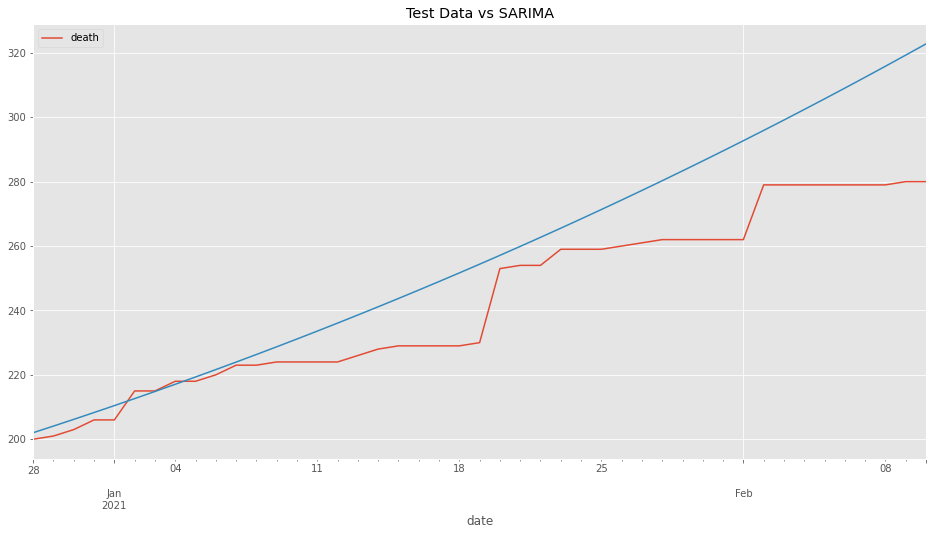

In [49]:
pd.DataFrame(test_data['death']).plot(figsize=(16,8),legend=True,title='Test Data vs SARIMA',grid=True)
plt.plot(pd.DataFrame(predictions_AK))
plt.show()

In [50]:
model = sm.tsa.statespace.SARIMAX(df_alaska['death'], order=stepwise_fit.order
res = model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  death   No. Observations:                  342
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -776.623
Date:                Thu, 11 Feb 2021   AIC                           1561.246
Time:                        11:15:15   BIC                           1576.561
Sample:                    03-06-2020   HQIC                          1567.348
                         - 02-10-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0350      0.100     -0.349      0.727      -0.231       0.161
drift          0.0002      0.000      0.430      0.667      -0.001       0.001
ma.L1         -0.8785      0.024    -36.079      0.0

In [51]:
fcast = res.predict(start=len(df_AK),end=len(df_AK)+45, typ='endogenous').rename('SARIMAX FORECAST')

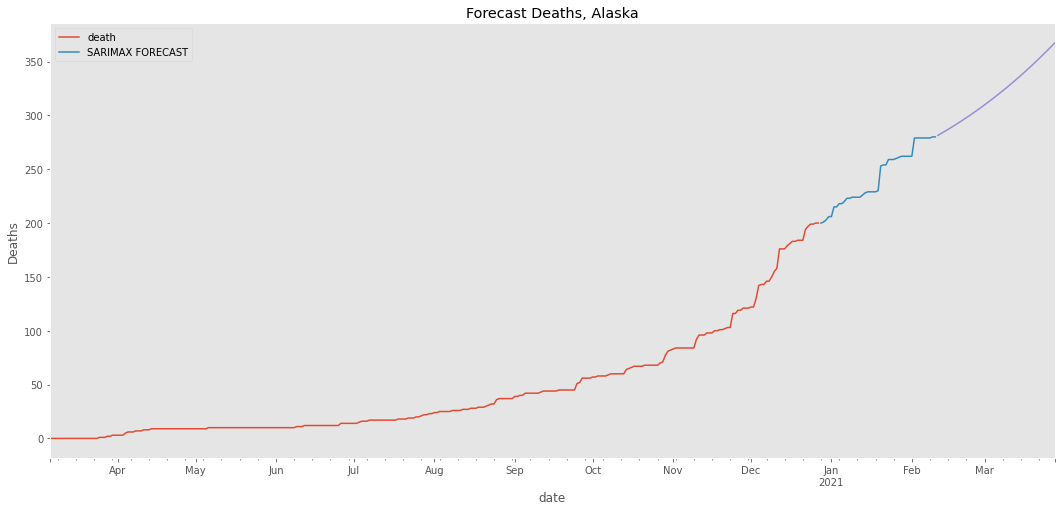

In [52]:
fig, ax = plt.subplots()

train_data['death'].plot(figsize=(16,8),legend=True,ylabel='Deaths',title='Forecast Deaths, Alaska',grid=True);
test_data['death'].plot(grid=True);
fcast.plot(legend=True,figsize=(18,8)); 
ax.grid();
plt.show();

#### Below graph will show prediction data against test data as well as a separate future forecast.

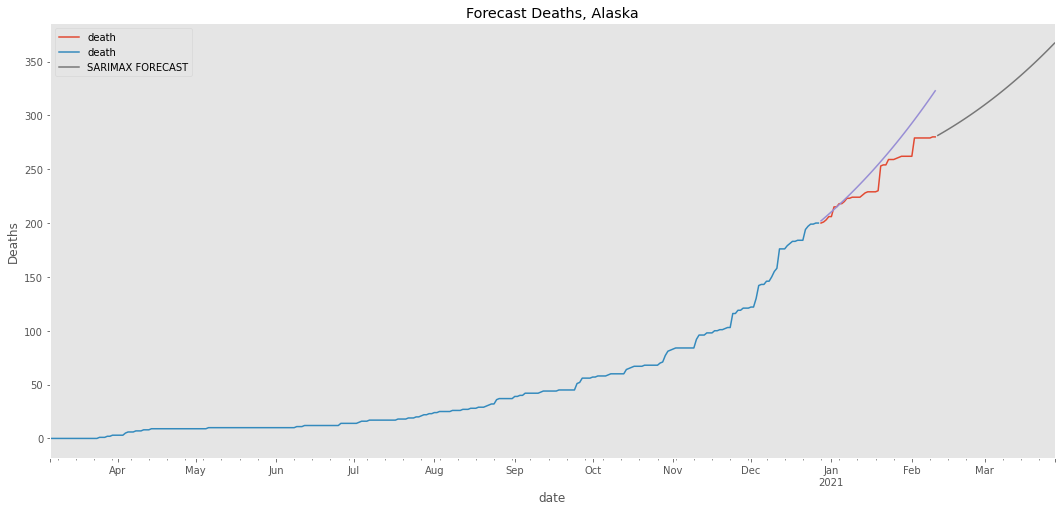

In [53]:
fig, ax = plt.subplots()

test_data['death'].plot(figsize=(16,8),legend=True,title='Forecast Deaths, Alaska',grid=True);
train_data['death'].plot(figsize=(16,8),legend=True,ylabel='Deaths',grid=True);
plt.plot(pd.DataFrame(predictions_AK)); # 'FORECAST' FROM END OF TRAINING DATA
fcast.plot(legend=True,figsize=(18,8)); # SARIMA FORECAST
ax.grid();
plt.show();

## SARIMAX Modeling - Forecasts include 95% confidence intervals in the graphed data. 

### New York State Ventilator Usage Forecast

#### NY State was one of the first states to experience the worst of the pandemic. In addition to this, they are one of the most populous states in the country, and have had a spike in Covid cases post-holidays. California just passed barely has passed New York state in total deaths related to COVID-19. 

In [ ]:
# change to True, run cell to follow link
open_links = False

import webbrowser

if open_links == True:
    webbrowser.open("https://deadline.com/2021/02/california-south-african-covid-19-variant-found-gavin-newsom-1234691514/")

In [152]:
df = state_dataframe(df_states, 'NY')

Successfully returned indexed dataframe for NY


In [153]:
df_ref = state_dataframe(df_states, 'NY')

Successfully returned indexed dataframe for NY


In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 346 entries, 2020-03-02 to 2021-02-10
Freq: D
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   state                  346 non-null    object 
 1   death                  346 non-null    float64
 2   inIcuCurrently         346 non-null    float64
 3   onVentilatorCurrently  346 non-null    float64
 4   positive               346 non-null    float64
 5   hospitalizedCurrently  346 non-null    float64
 6   deathIncrease          346 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 21.6+ KB


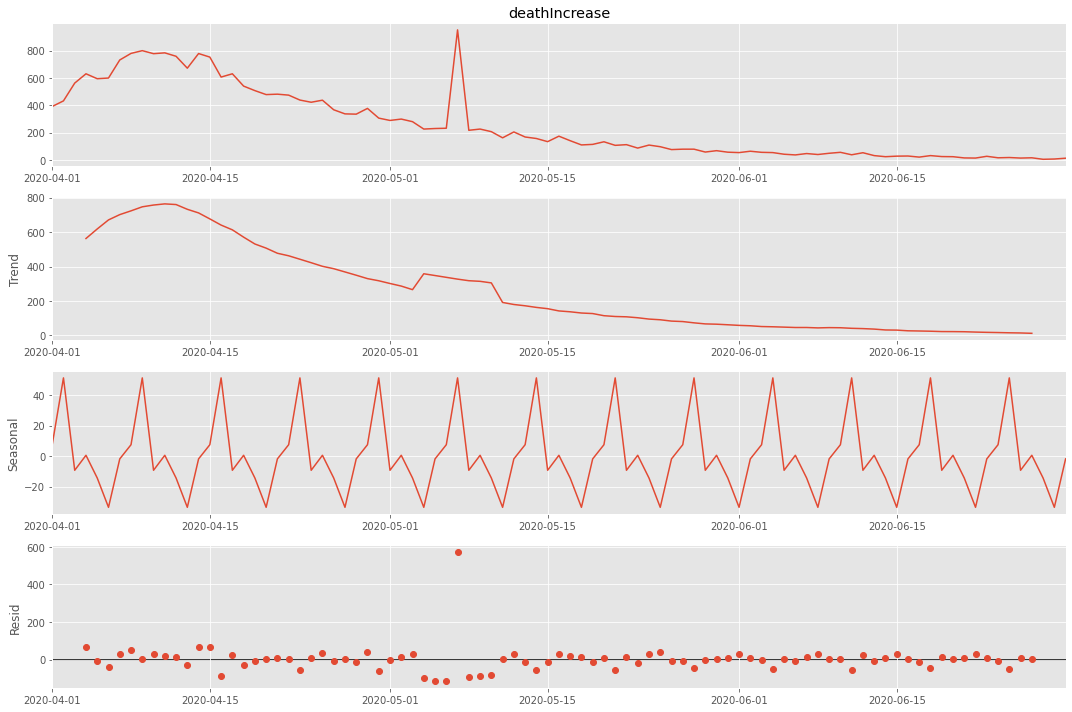

In [155]:
plt.rcParams['figure.figsize']=(15,10);
sd(df.loc['04-2020':'06-2020']['deathIncrease']).plot();

In [156]:
# death increase seasonal decomp plot shows that we have near weekly seasonality. 

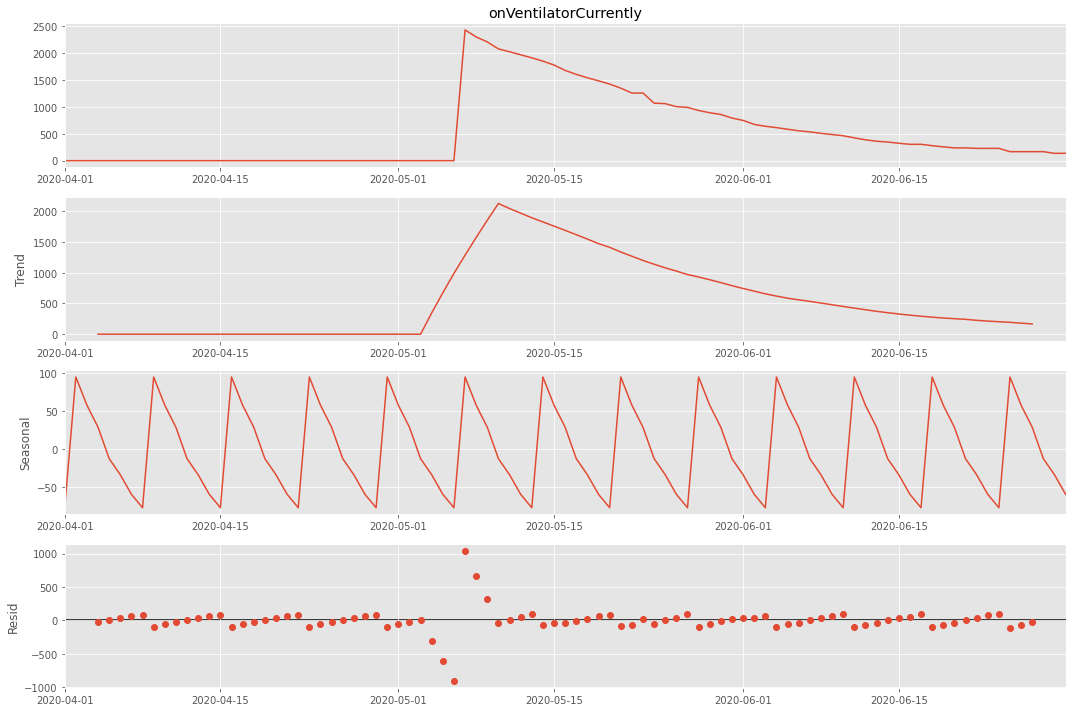

In [157]:
plt.rcParams['figure.figsize']=(15,10);
sd(df.loc['04-2020':'06-2020']['onVentilatorCurrently']).plot();

In [158]:
# seasonality peaks match the peaks of the deathIncrease seasonal decomp.

ARIMA order is:  (4, 2, 4)
Seasonal ARIMA order is:  (1, 0, 1, 6)
Use ARIMA object stepwise_fit to store ARIMA and seasonal ARIMA orders in variables.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:               onVentilatorCurrently   No. Observations:                  240
Model:             SARIMAX(4, 2, 4)x(1, 0, [1], 6)   Log Likelihood                -862.765
Date:                             Thu, 11 Feb 2021   AIC                           1747.529
Time:                                     13:24:29   BIC                           1785.204
Sample:                                 05-17-2020   HQIC                          1762.731
                                      - 01-11-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9412      0.072    -27.018      0.000      -2.082      -1.800
ar.L2         -2.0117      0.101    -20.016      0.000      -2.209      -1.815
ar.L3         -1.3848      0.092    -15.046      0.000      -1.565      -1.204
ar.L4         -0.4881      0.050     -9.857      0.000      -0.585      -0.391
ma.L1          1.0841      0.077     14.070      0.000       0.933       1.235
ma.L2          0.2846      0.082      3.471      0.001       0.124       0.445
ma.L3         -0.4837      0.084     -5.790      0.000      -0.647      -0.320
ma.L4         -0.4968      0.087     -5.726      0.000      -0.667      -0.327
ar.S.L6       -0.0180      0.025     -0.710      0.478      -0.068       0.032
ma.S.L6        0.1417      0.072      1.959      0.050   -7.07e-05       0.283
sigma2       116.8609      7.080     16.505      0.000     102.984     130.738
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               193.95
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                            -0.39
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

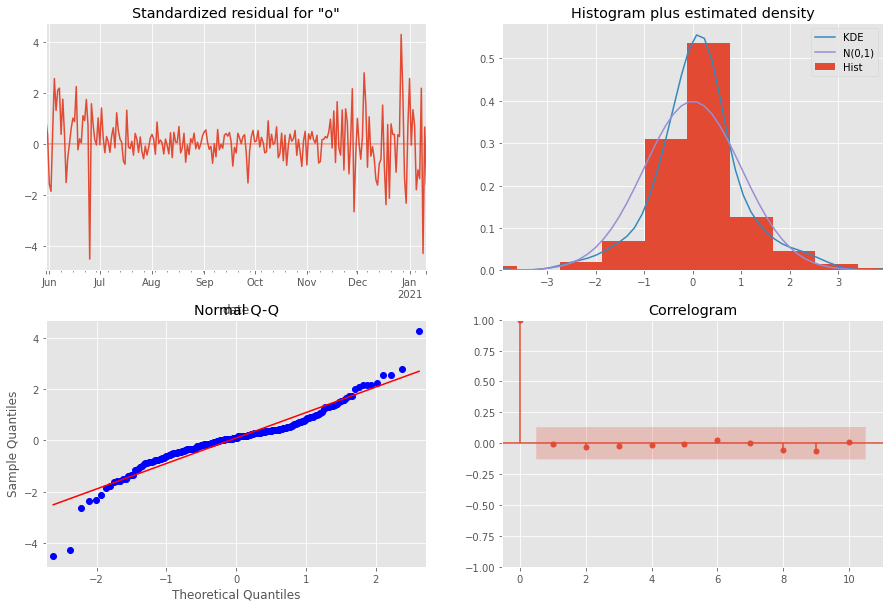

In [159]:
stepwise_fit, stepwise_full, results, results_full = arima_tune(df, 'onVentilatorCurrently', days_to_forecast=30, m_periods=6, verbose=True) 
# train days arg defaults to 270 days, but can be changed. seasonality can be adjusted as well
# see docstring for further details

#### Reasonable q-q plot. Model summary is good overall. 

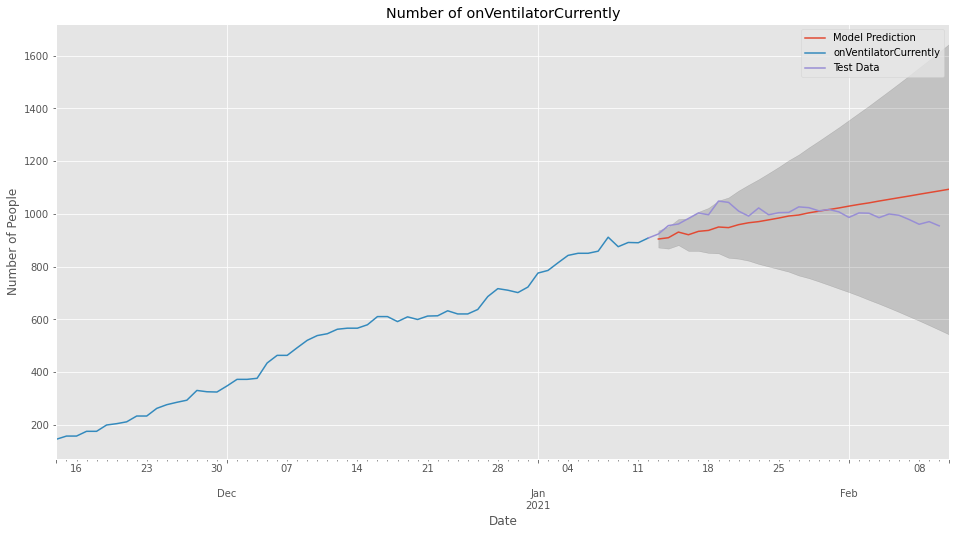

In [160]:
evaluate_predictions(results, df, 'onVentilatorCurrently', stepwise_fit=stepwise_fit, alpha=.05, days_to_forecast=30)
# plot training time and test time
# this evaluates the model using a train test split while also providing
# a forecast of confidence intervals with an alpha of .05. 

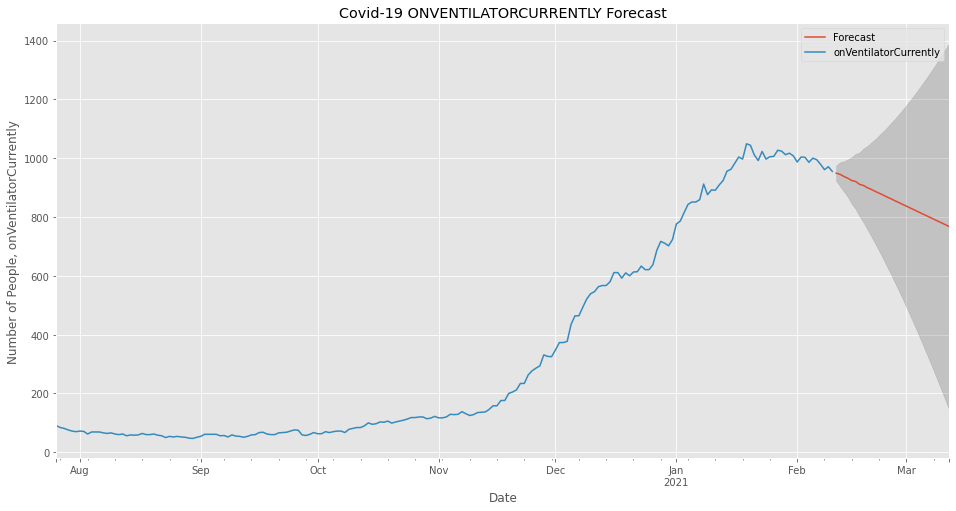

In [161]:
exog_forecast, forecast_obj = build_SARIMAX_forecast(model=results_full, 
                                                     dataframe=df, 
                                                     target_column='onVentilatorCurrently', 
                                                     days_to_forecast=30, stepwise_fit=stepwise_full, 
                                                     alpha=.05)

# this is a forecast of those people who are currently on ventilators in cases
# involving Covid-19. This forecast data will be used to enhance the overall 
# forecast of death or deathIncrease (rate of death)

#### New York ventilator data has shown an improvement more recently. The recent downward trend here is encouraging, and it is likely to continue.
#### However, the initial spike in ventilator usage in New York (seen below) was a result of not knowing how to properly treat the virus. As time has progressed we have learned that ventilators should only be used as truly a last resort, meaning that someone will be nearing death's door before they are put on it. Additional methods like keeping Covid patients on their stomachs while using the ventilator has been claimed to be effective. 
#### Finally, this forecast will be used to influence a forecast of deaths in New York.

##### Recommendations include

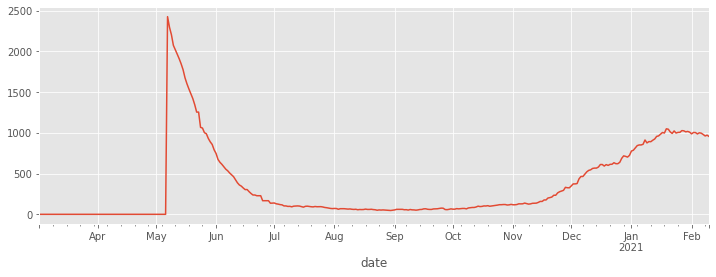

In [162]:
df['onVentilatorCurrently'].plot(figsize=(12,4)); # see spike here coming down 
# from initial May 2020 reporting. 

### New York State Deaths Forecast 
#### Modeled using New York's Ventilator Usage Forecast

In [163]:
stepwise_fit, df_forecast = get_exogenous_forecast_dataframe(dataframe=df,
                                                             original_dataframe=df_ref,
                                                             exog_forecast=exog_forecast, 
                                                             target_column='death',
                                                             exogenous_column='onVentilatorCurrently',
                                                             days_to_forecast=30,
                                                             m_periods=6)

In [164]:
df_forecast.tail(5)

,state,death,inIcuCurrently,onVentilatorCurrently,positive,hospitalizedCurrently,deathIncrease
2021-03-08,NaN,NaN,NaN,792.821167,NaN,NaN,NaN
2021-03-09,NaN,NaN,NaN,786.451726,NaN,NaN,NaN
2021-03-10,NaN,NaN,NaN,780.196028,NaN,NaN,NaN
2021-03-11,NaN,NaN,NaN,773.858953,NaN,NaN,NaN
2021-03-12,NaN,NaN,NaN,767.570458,NaN,NaN,NaN


In [165]:
full_exog_model = SARIMAX(df['death'],df['onVentilatorCurrently'],
                          order=stepwise_fit.order,seasonal_order=stepwise_fit.seasonal_order)

In [166]:
# fit model 
model = full_exog_model.fit()

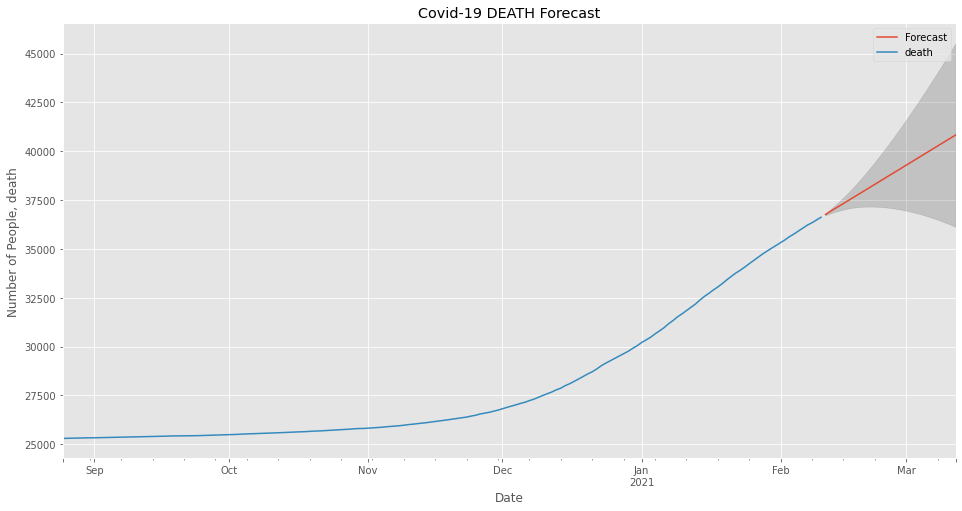

In [167]:
exog_forecast, results_forecast = build_SARIMAX_forecast(model=model,
                                                         dataframe=df_forecast, 
                                                         target_column='death', 
                                                         days_to_forecast=30, 
                                                         stepwise_fit=stepwise_fit, 
                                                         alpha=.05,
                                                         original_df=df_ref,
                                                         exogenous_column='onVentilatorCurrently')

In [173]:
results_forecast.conf_int()[-5:]

,lower death,upper death
2021-03-08,36489.278169,44047.592976
2021-03-09,36404.381659,44412.949094
2021-03-10,36315.193207,44782.663267
2021-03-11,36221.737427,45156.597468
2021-03-12,36124.128882,45534.712669


In [171]:
# Note: issue here is that deaths can not decrease per the lower bound
# of the confidence interval. Assume the lower bound flattens to a rate of
# zero deaths, which is completely possible if the virus stopped spreading
# in New York. 

### New York Analysis and Recommendations

#### New York flattened its curve from the beginning of the pandemic until the Thanksgiving holidays when everything suddenly became more difficult. There is a clear increase in deaths beginning around mid November and into Christmas and the New Year, remaining unhelped as the virus survives more easily in the cold just as other respiratory viruses and the flu. 
#### There is every possibility that without continuing social distancing and enforcing the wearing of masks that the rate of death will once again increase.

##### Recommendations include

### California Deaths Forecast
#### Modeled using ICU Forecast (ICU Forecast not shown)

In [178]:
# change to True, run cell to follow link
open_links = False

import webbrowser

if open_links == True:
    webbrowser.open("https://deadline.com/2021/02/california-south-african-covid-19-variant-found-gavin-newsom-1234691514/")

In [179]:
df_ref = state_dataframe(df_states, 'CA')

Successfully returned indexed dataframe for CA


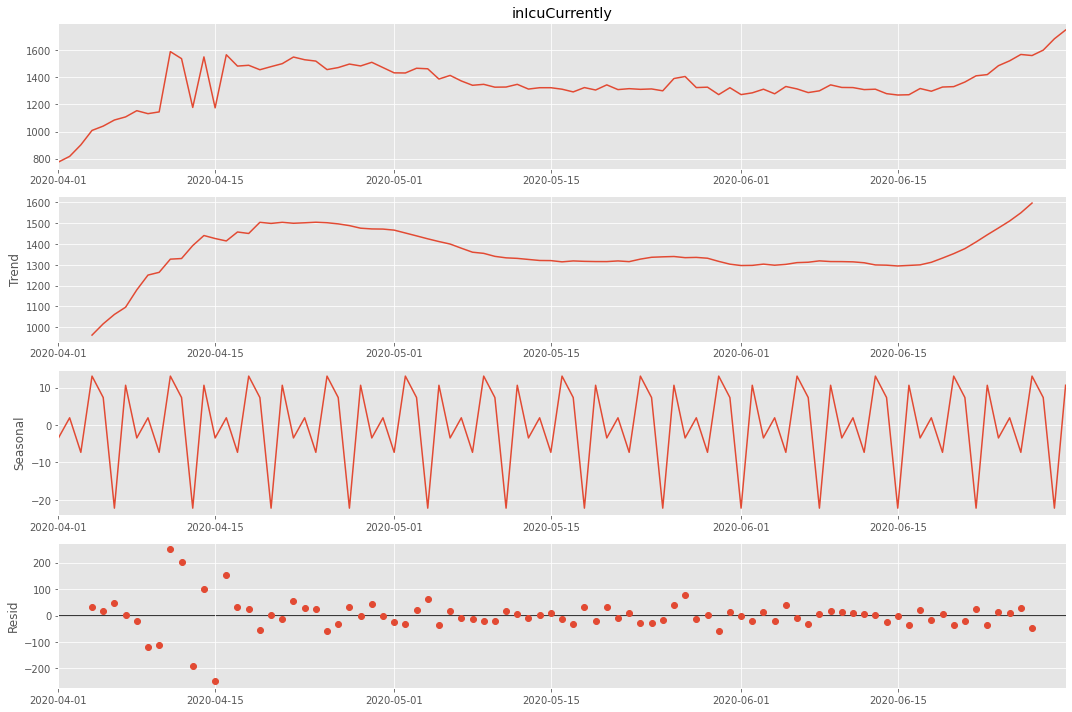

In [180]:
plt.rcParams['figure.figsize']=(15,10);
sd(df_ref.loc['04-2020':'06-2020']['inIcuCurrently']).plot();

Successfully returned indexed dataframe for CA
ARIMA order is:  (1, 2, 2)
Seasonal ARIMA order is:  (0, 0, 0, 7)
Use ARIMA object stepwise_fit to store ARIMA and seasonal ARIMA orders in variables.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         inIcuCurrently   No. Observations:                  240
Model:               SARIMAX(1, 2, 2)   Log Likelihood               -1172.650
Date:                Thu, 11 Feb 2021   AIC                           2353.300
Time:                        13:38:30   BIC                           2367.139
Sample:                    05-17-2020   HQIC                          2358.879
                         - 01-11-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8865      0.077    -11.538      0.000      -1.037      -0.736
ma.L1         -0.0553      0.108     -0.510      0.610      -0.268       0.157
ma.L2         -0.6589      0.098     -6.743      0.000      -0.850      -0.467
sigma2      1261.4033     98.874     12.758      0.000    1067.613    1455.193
===================================================================================
Ljung-Box (L1) (Q):                   0.99   Jarque-Bera (JB):                23.19
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -0.59
Prob(H) (two-sided):                  0.42   Kurtosis:                         3.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

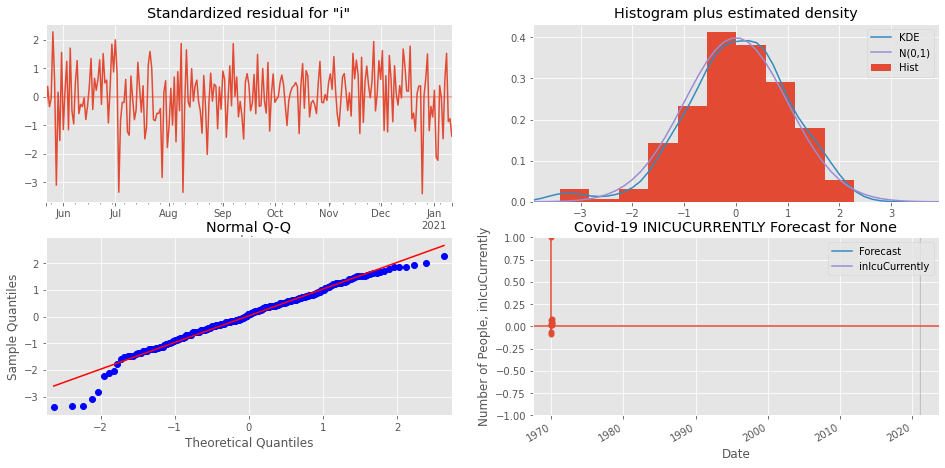

In [181]:
state_dataframe, exog_forecast = create_exog_forecast(df_states, 'inIcuCurrently', m_periods=7, state_postal_code='CA')

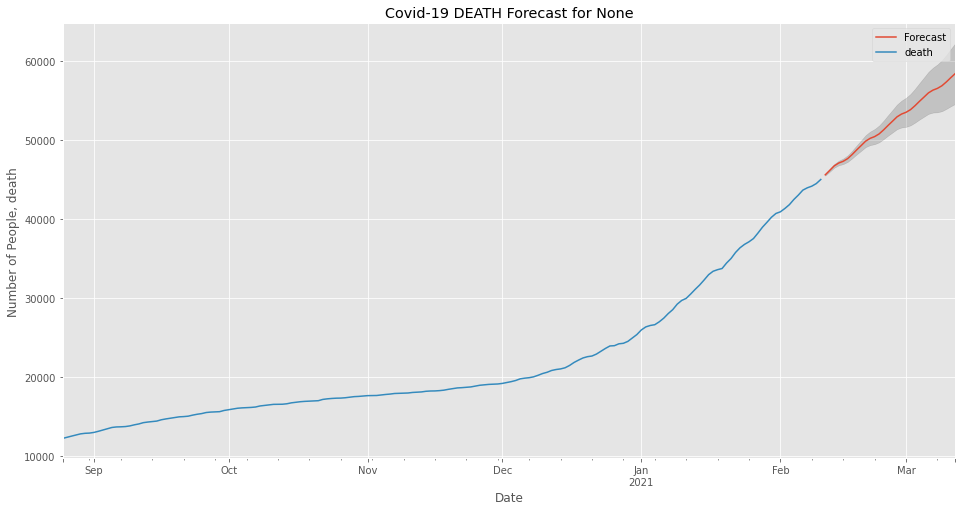

In [182]:
forecast_object = graph_exog_forecast(dataframe=state_dataframe, 
                                      target_column='death', 
                                      exogenous_column='inIcuCurrently', 
                                      exog_forecast=exog_forecast,
                                      df_ref=df_ref, 
                                      alpha=.05, days_to_forecast=30, 
                                      train_days=270, m_periods=7)

In [183]:
forecast_object.predicted_mean[-5:] # projected mean deaths for
# by the end of March 

2021-03-08    56511.505268
2021-03-09    56843.212371
2021-03-10    57333.019978
2021-03-11    57878.727096
2021-03-12    58398.849332
Freq: D, Name: predicted_mean, dtype: float64

### California Analysis and Recommendations

####

##### Recommendations include

### Texas Hospitalized Forecast

In [ ]:
# change to True, run cell to follow link
open_links = False

import webbrowser

if open_links == True:
    webbrowser.open(

#### Texas is also a populous state and also has been inclined to open back up quickly to keep the economy going. Additionally, they have not reported ICU or Ventilator numbers to the Covid Tracking Project. 

In [185]:
df = state_dataframe(df_states, 'TX')

TypeError: 'DataFrame' object is not callable

In [ ]:
df_ref = state_dataframe(df_states, 'TX')

In [ ]:
df.info()

In [ ]:
plt.rcParams['figure.figsize']=(15,10);
sd(df.loc['04-2020':'06-2020']['hospitalizedCurrently']).plot();

ARIMA order is:  (4, 2, 3)
Seasonal ARIMA order is:  (1, 0, 1, 6)
Use ARIMA object stepwise_fit to store ARIMA and seasonal ARIMA orders in variables.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:               hospitalizedCurrently   No. Observations:                  240
Model:             SARIMAX(4, 2, 3)x(1, 0, [1], 6)   Log Likelihood               -1189.506
Date:                             Thu, 11 Feb 2021   AIC                           2399.012
Time:                                     13:41:41   BIC                           2433.305
Sample:                                 05-17-2020   HQIC                          2412.848
                                      - 01-11-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8691      0.129      6.750      0.000       0.617       1.121
ar.L2         -0.9564      0.117     -8.197      0.000      -1.185      -0.728
ar.L3          0.1270      0.082      1.554      0.120      -0.033       0.287
ar.L4         -0.4490      0.071     -6.330      0.000      -0.588      -0.310
ma.L1         -1.5408      0.149    -10.367      0.000      -1.832      -1.249
ma.L2          1.1776      0.217      5.437      0.000       0.753       1.602
ma.L3         -0.1653      0.140     -1.183      0.237      -0.439       0.109
ar.S.L6       -0.2120      0.100     -2.122      0.034      -0.408      -0.016
ma.S.L6        0.0135      0.124      0.109      0.913      -0.230       0.257
sigma2      2173.1880    161.699     13.440      0.000    1856.263    2490.113
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               149.29
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               3.75   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

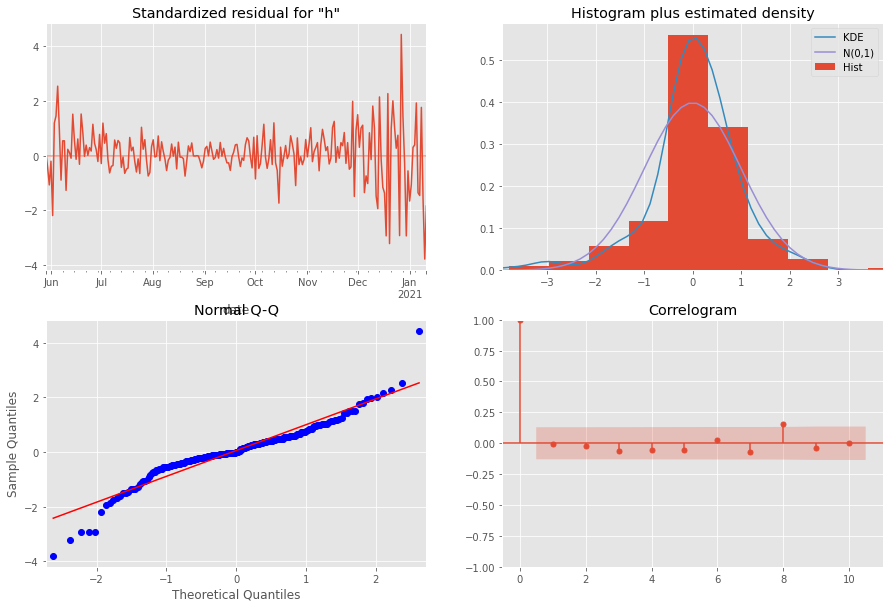

In [186]:
stepwise_fit, stepwise_full, results, results_full = arima_tune(df, 'hospitalizedCurrently', days_to_forecast=30, m_periods=6, verbose=True) 
# train days arg defaults to 270 days, but can be changed. seasonality can be adjusted as well
# see docstring for further details

#### The ends of the q-q plot are not quite in line.

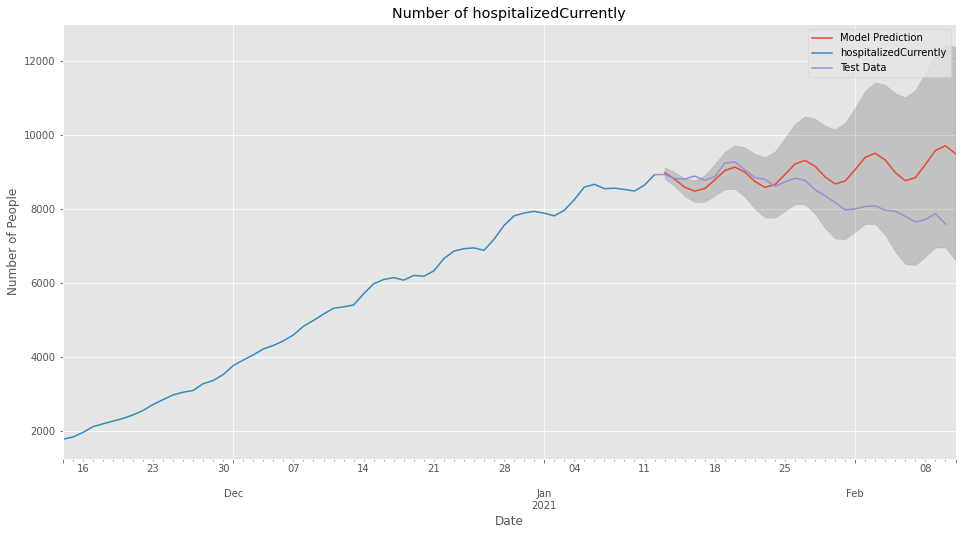

In [187]:
evaluate_predictions(results, df, 'hospitalizedCurrently', stepwise_fit=stepwise_fit, alpha=.05, days_to_forecast=30)
# plot training time and test time

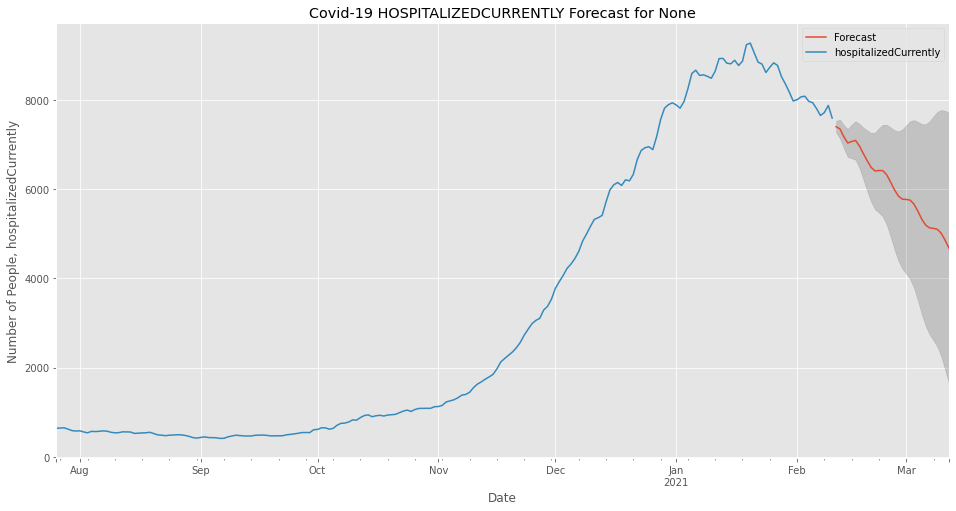

In [188]:
exog_forecast, forecast_obj = build_SARIMAX_forecast(model=results_full, 
                                                     dataframe=df, 
                                                     target_column='hospitalizedCurrently', 
                                                     days_to_forecast=30, stepwise_fit=stepwise_full, 
                                                     alpha=.05)

### Texas Deaths Forecast
#### Modeled using Texas's Hospitalized Forecast

In [74]:
stepwise_fit, df_forecast = get_exogenous_forecast_dataframe(dataframe=df,
                                                             original_dataframe=df_ref,
                                                             exog_forecast=exog_forecast, 
                                                             target_column='death',
                                                             exogenous_column='hospitalizedCurrently',
                                                             days_to_forecast=30,
                                                             m_periods=6)

In [75]:
stepwise_fit.seasonal_order

(1, 0, 0, 6)

In [76]:
df_forecast.tail(5)

,state,death,inIcuCurrently,onVentilatorCurrently,positive,hospitalizedCurrently,deathIncrease
2021-03-08,NaN,NaN,NaN,NaN,NaN,5854.908822,NaN
2021-03-09,NaN,NaN,NaN,NaN,NaN,5771.989334,NaN
2021-03-10,NaN,NaN,NaN,NaN,NaN,5691.512948,NaN
2021-03-11,NaN,NaN,NaN,NaN,NaN,5613.407683,NaN
2021-03-12,NaN,NaN,NaN,NaN,NaN,5537.603677,NaN


In [77]:
full_exog_model = SARIMAX(df['death'],df['hospitalizedCurrently'],
                          order=stepwise_fit.order,seasonal_order=stepwise_fit.seasonal_order)

In [78]:
# fit model 
model = full_exog_model.fit()

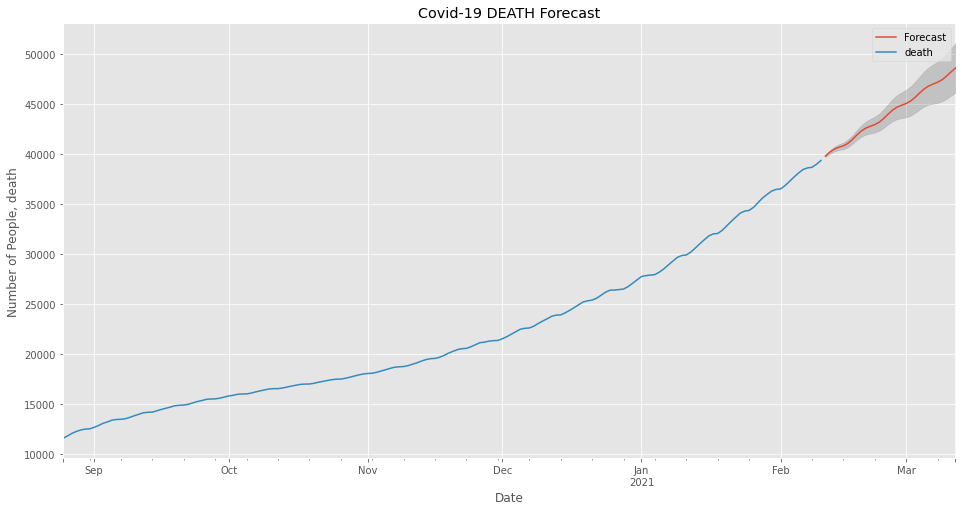

In [79]:
exog_forecast, results_forecast = build_SARIMAX_forecast(model=model,
                                                         dataframe=df_forecast, 
                                                         target_column='death', 
                                                         days_to_forecast=30, 
                                                         stepwise_fit=stepwise_fit, 
                                                         alpha=.05,
                                                         original_df=df_ref,
                                                         exogenous_column='hospitalizedCurrently')

In [80]:
results_forecast.predicted_mean[-5:]

2021-03-08    47209.746261
2021-03-09    47461.749201
2021-03-10    47822.623294
2021-03-11    48246.760272
2021-03-12    48642.591922
Freq: D, Name: predicted_mean, dtype: float64

### Texas Analysis and Recommendations

####

##### Recommendations include

### Florida Rate of Death
#### Modeled using Hospitalized Currently Forecast

In [112]:
# change to True, run cell to follow link
open_links = True

import webbrowser

if open_links == True:
    webbrowser.open("https://www.newsweek.com/covid-florida-travel-advice-state-new-uk-variant-cases-1568572")

#### Florida currently has 300 new cases of the UK variant of Covid with 0 travel restrictions in place. The spread of the virus within Florida and throughout the rest of the United States as a result of a lack of travel bans and restraint is a serious issue. This section will forecast rate of death, total deaths, and will use the number of people currently hospitalized as an exogeous forecast. (data as of 2-10-2021)

In [100]:
df_ref = state_dataframe(df_states, 'FL')

Successfully returned indexed dataframe for FL


In [102]:
df_ref.tail()

,state,death,inIcuCurrently,onVentilatorCurrently,positive,hospitalizedCurrently,deathIncrease
date,,,,,,,
2021-02-06,FL,28058.0,0.0,0.0,1739276.0,5377.0,145
2021-02-07,FL,28161.0,0.0,0.0,1745744.0,5381.0,103
2021-02-08,FL,28287.0,0.0,0.0,1751343.0,5381.0,126
2021-02-09,FL,28526.0,0.0,0.0,1758254.0,5307.0,239
2021-02-10,FL,28691.0,0.0,0.0,1765659.0,5129.0,165


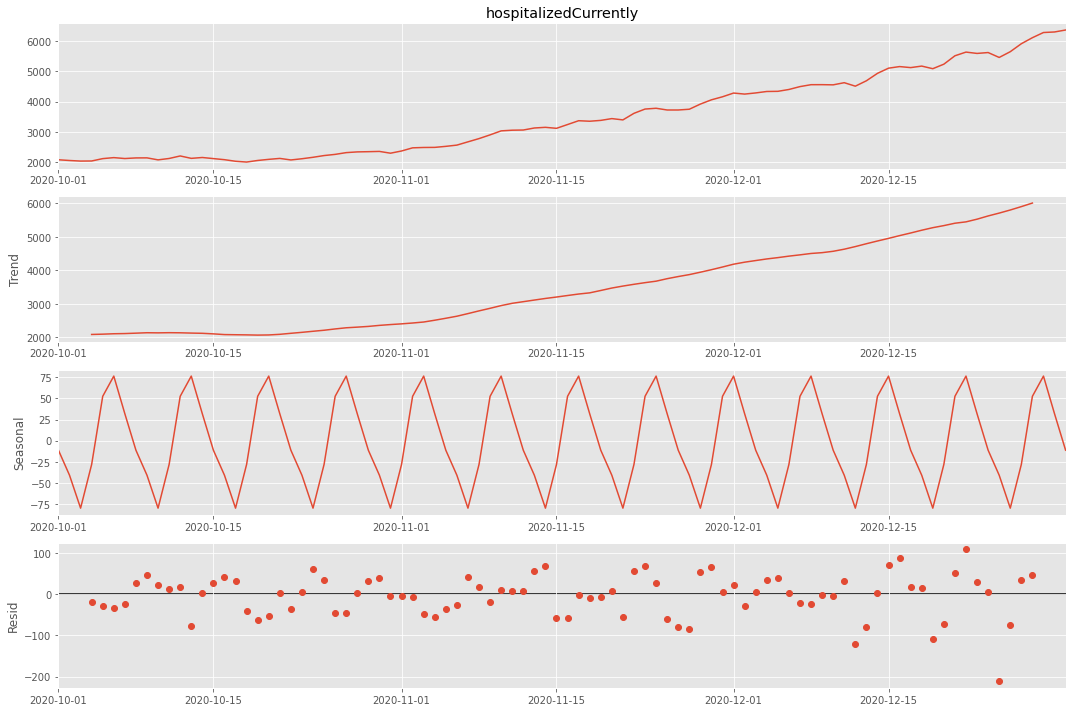

In [104]:
plt.rcParams['figure.figsize']=(15,10);
sd(df_ref.loc['10-2020':'12-2020']['hospitalizedCurrently']).plot(); # seasonality of about 6-7 days

Successfully returned indexed dataframe for FL
ARIMA order is:  (0, 1, 0)
Seasonal ARIMA order is:  (0, 0, 1, 6)
Use ARIMA object stepwise_fit to store ARIMA and seasonal ARIMA orders in variables.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:               hospitalizedCurrently   No. Observations:                  225
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 6)   Log Likelihood               -1650.228
Date:                             Thu, 11 Feb 2021   AIC                           3304.456
Time:                                     11:46:24   BIC                           3311.216
Sample:                                 05-17-2020   HQIC                          3307.187
                                      - 12-27-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L6        0.1482      0.237      0.626      0.531      -0.316       0.612
sigma2      2.359e+05   2293.562    102.841      0.000    2.31e+05     2.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):            337054.56
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               0.01   Skew:                            13.55
Prob(H) (two-sided):                  0.00   Kurtosis:                       194.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

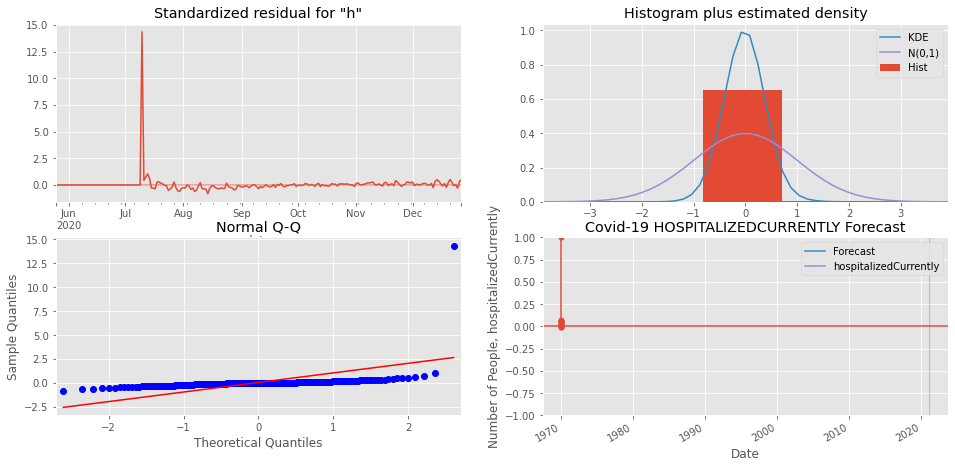

In [107]:
state_dataframe, exog_forecast = create_exog_forecast(df_states, 'hospitalizedCurrently', days_to_forecast=45, m_periods=6, state_postal_code='FL')

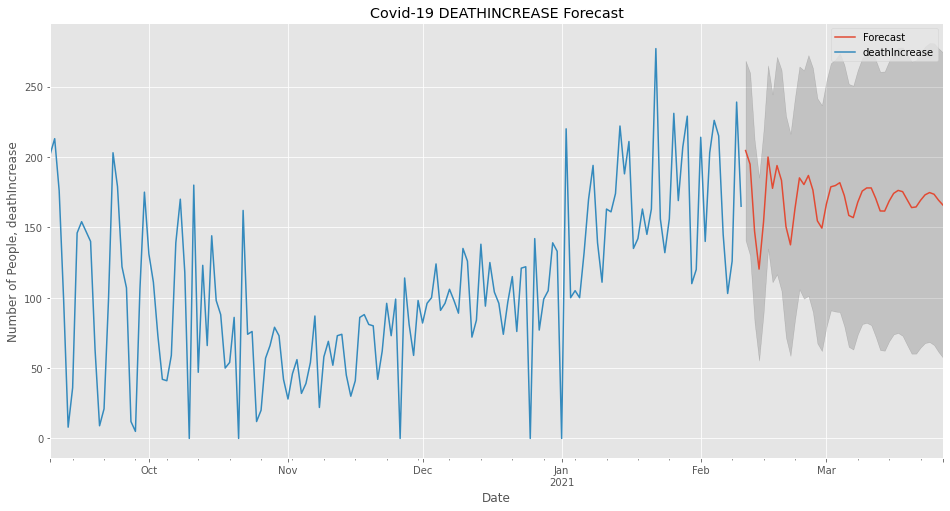

In [108]:
forecast_object = graph_exog_forecast(dataframe=state_dataframe, 
                                      target_column='deathIncrease', 
                                      exogenous_column='hospitalizedCurrently', 
                                      exog_forecast=exog_forecast,
                                      df_ref=df_ref, 
                                      alpha=.05, days_to_forecast=45, 
                                      train_days=270, m_periods=7)

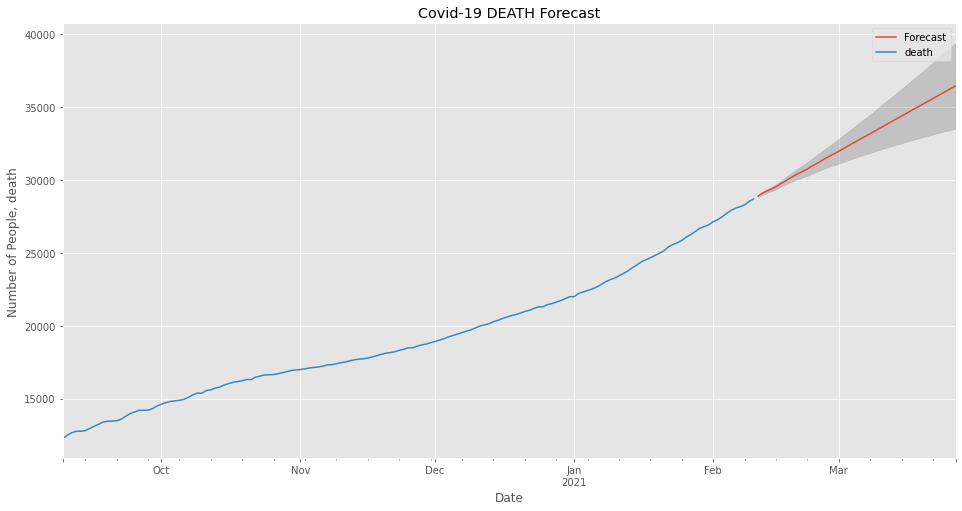

In [110]:
forecast_object = graph_exog_forecast(dataframe=state_dataframe, 
                                      target_column='death', 
                                      exogenous_column='hospitalizedCurrently', 
                                      exog_forecast=exog_forecast,
                                      df_ref=df_ref, 
                                      alpha=.05, days_to_forecast=45, 
                                      train_days=270, m_periods=7)

In [111]:
forecast_object.predicted_mean[-5:] # projected mean deaths for
# by the end of March 

2021-03-23    35753.698815
2021-03-24    35925.351971
2021-03-25    36098.183050
2021-03-26    36270.928971
2021-03-27    36442.292857
Freq: D, Name: predicted_mean, dtype: float64

### Florida Analysis and Recommendations

####

##### Recommendations include

# Recommendations and Conclusions

## Questions

### Question 1

### Question 2

### Question 3

## Conclusions

## Future Work

# Appendix

## Using an Exogenous Variable with SARIMAX

In [92]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

calendar = calendar()
holidays = calendar.holidays(start=df_states.index.min(), end=df_states.index.max())

df_states['holiday'] = df_states.index.isin(holidays)

df_whole_US['holiday'] = df_whole_US.index.isin(holidays)

In [ ]:
df_states = sort_and_clean_df(df_states,.05)

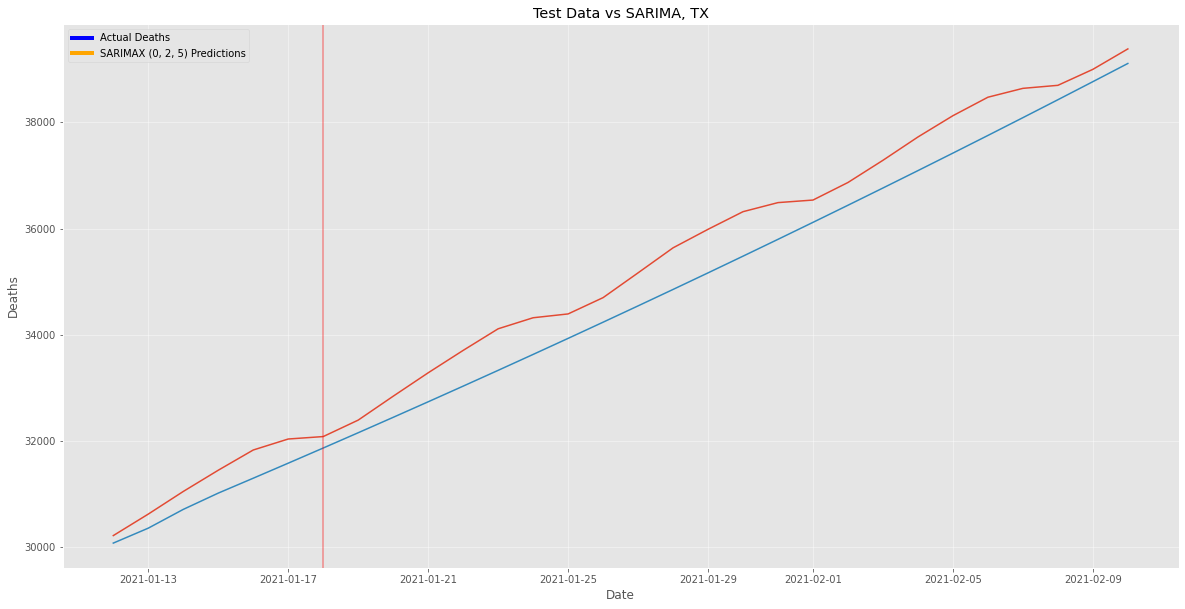

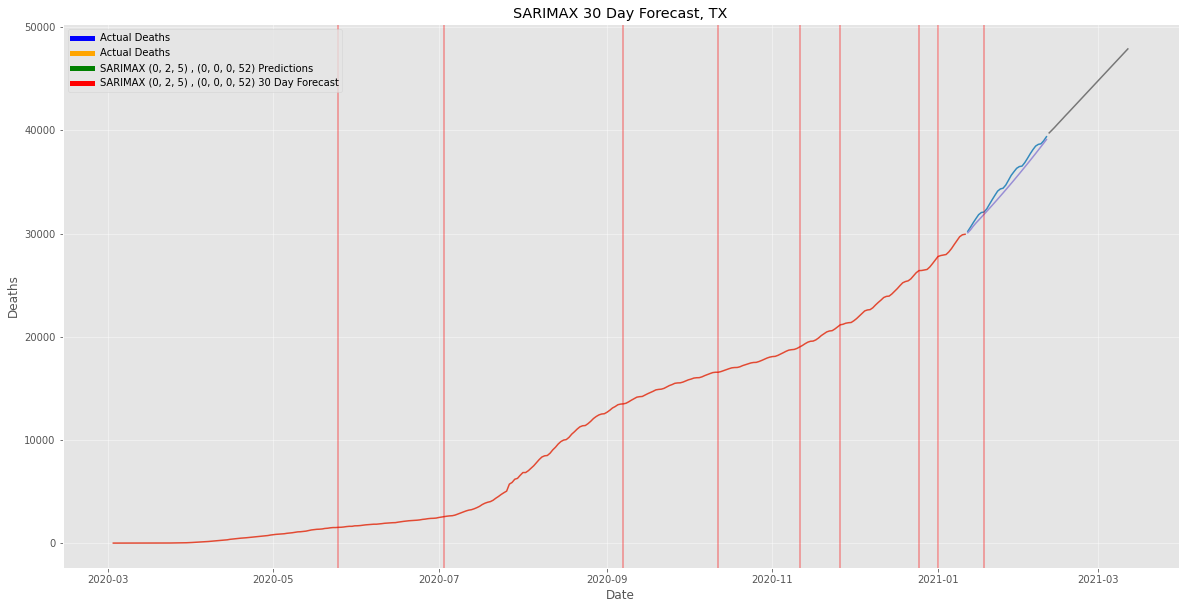

SyntaxError: 'return' outside function (<ipython-input-94-18377b5ffa97>, line 103)

In [94]:
state_postal_code = 'TX'
days = 30

df_state = df_states[df_states['state']==state_postal_code]    

# sort index, lowest index to oldest date, drop na's in death column
df_state = df_state.sort_index()
df_state = df_state.dropna(subset=['death'])
df_state_new = pd.DataFrame(df_state)

#     ets_decomp = sd(df_state_new['death'])
#     ets_decomp.plot();

# create stepwise fit model, see summary
stepwise_fit = auto_arima(df_state_new['death'],seasonal=True,m=52,maxiter=2)

# auto_arima automatically differences and returns that differencing for the model in the arima_order = stepwise_fit.order below
## find correct ARIMA order

arima_order = stepwise_fit.order
seasonal_order = stepwise_fit.seasonal_order

length = len(df_state_new)-days

train_data = df_state_new.iloc[:length]
test_data = df_state_new.iloc[length:]

model = sm.tsa.statespace.SARIMAX(train_data['death'], trend='ct', seasonal_order=seasonal_order, 
                                  order=arima_order, enforce_invertibility=False)
res = model.fit()

start = len(train_data)
end = len(train_data) + len(test_data) - 1

predictions_state = res.predict(start,end,dynamic=False).rename(f'SARIMAX {arima_order} Predictions')

# ensure predictions are in DataFrame format, label index as date to match df_alaska
predictions_state = pd.DataFrame(predictions_state)
predictions_state.index.name = 'date'

train_data.index.freq = 'D'
test_data.index.freq = 'D' # -1D is reverse index, ie most recent date is at top of dataframe
# perform sort_index on dataframe to correct. set frequencies to match for plotting
# on same visualization

# graph test vs. prediction data - {PLOT}
legend_elements = [Line2D([0], [0], color='b', lw=4, label='Actual Deaths'),
                   Line2D([0], [0], color='#FFA500', lw=4, label=f'SARIMAX {arima_order} Predictions')]

fig, ax = plt.subplots(figsize=(20,10));
ax.plot(test_data['death'])
ax.plot(predictions_state);
ax.grid(b=True,alpha=.5)
plt.title(f'Test Data vs SARIMA, {state_postal_code}')
ax.legend(handles=legend_elements)
for x in test_data.index:
    if test_data['holiday'].loc[x]==1:    # for days where holiday == 1
        ax.axvline(x=x, color='red', alpha = 0.4);   
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.show();

error1 = mse(test_data['death'], predictions_state)
error2 = rmse(test_data['death'], predictions_state)

# print(f'SARIMAX{arima_order}{seasonal_order} MSE Error: {error1}')
# print(f'SARIMAX{arima_order}{seasonal_order} RMSE Error: {error2}')

# train model for forecast
model = sm.tsa.statespace.SARIMAX(df_state_new['death'],exog=df_state_new['holiday'],
                                  order=arima_order, seasonal_order=seasonal_order,
                                  enforce_invertibility=False)
res = model.fit(disp=False)

# create forecast
exog_forecast = df_state_new[length:][['holiday']]
fcast = res.predict(start=len(df_state_new),end=len(df_state_new)+days-1,exog=exog_forecast).rename(f'SARIMAX{arima_order},{seasonal_order} {days} Days Forecast')

# graph forecast deaths, breakout of train and test split is present in graph - {PLOT}
legend_elements = [Line2D([0], [0], color='b', lw=5, label='Actual Deaths'),
                   Line2D([0], [0], color='#FFA500', lw=5, label='Actual Deaths'),
                   Line2D([0], [0], color='g', lw=5, label=f'SARIMAX {arima_order} , {seasonal_order} Predictions'),
                   Line2D([0], [0], color='r', lw=5, label=f'SARIMAX {arima_order} , {seasonal_order} {days} Day Forecast')]

fig, ax = plt.subplots(figsize=(20,10));
ax.plot(train_data['death'])
ax.plot(test_data['death'])
ax.plot(predictions_state)
ax.plot(fcast)
ax.grid(b=True,alpha=.5)
plt.title(f'SARIMAX {days} Day Forecast, {state_postal_code}')
ax.legend(handles=legend_elements)
for x in df_state_new.index:
    if df_state_new['holiday'].loc[x]==1:    # for days where holiday == 1
        ax.axvline(x=x, color='red', alpha = 0.4);   
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.show();

last_predictions = len(fcast)-5
actual_numbers = fcast[last_predictions:]

return actual_numbers

## Univariate Forecast with RNN

### Texas

Epoch 1/4
295/295 [==============================] - 9s 28ms/step - loss: 0.0223
Epoch 2/4
295/295 [==============================] - 8s 29ms/step - loss: 8.9686e-04
Epoch 3/4
295/295 [==============================] - 8s 28ms/step - loss: 0.0013
Epoch 4/4
295/295 [==============================] - 8s 28ms/step - loss: 4.9281e-04


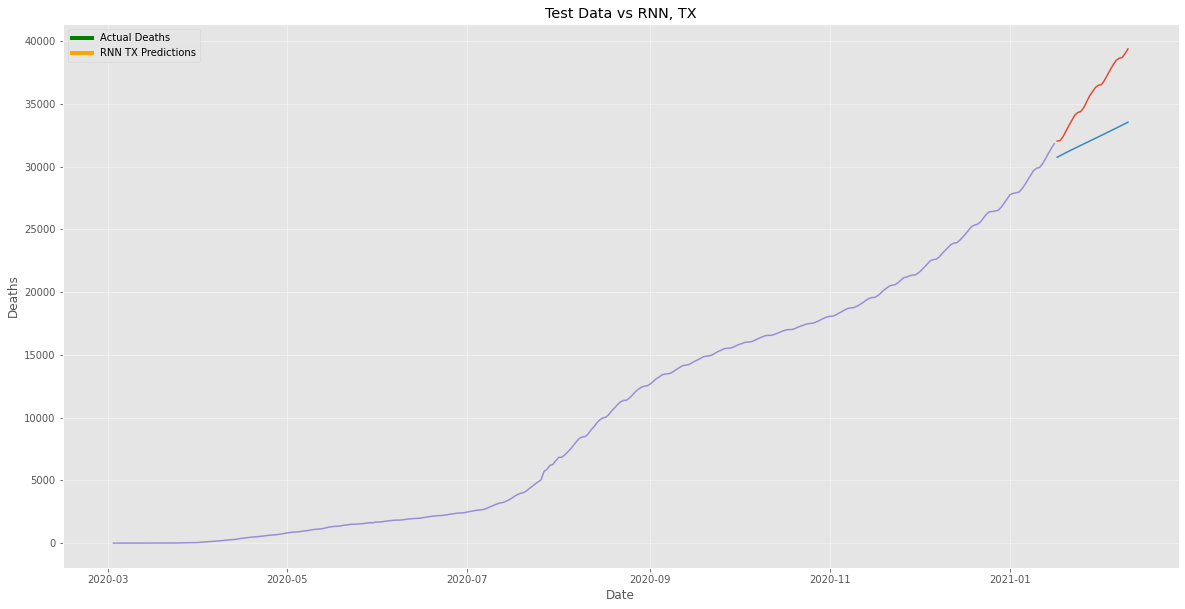

In [96]:
create_NN_predict(df_states=df_states,state_postal_code='TX',days=25,epochs=4) 

### Florida

Epoch 1/4
339/339 [==============================] - 8s 21ms/step - loss: 0.0207
Epoch 2/4
339/339 [==============================] - 8s 22ms/step - loss: 0.0020
Epoch 3/4
339/339 [==============================] - 8s 22ms/step - loss: 2.1629e-04
Epoch 4/4
339/339 [==============================] - 8s 22ms/step - loss: 2.3257e-04


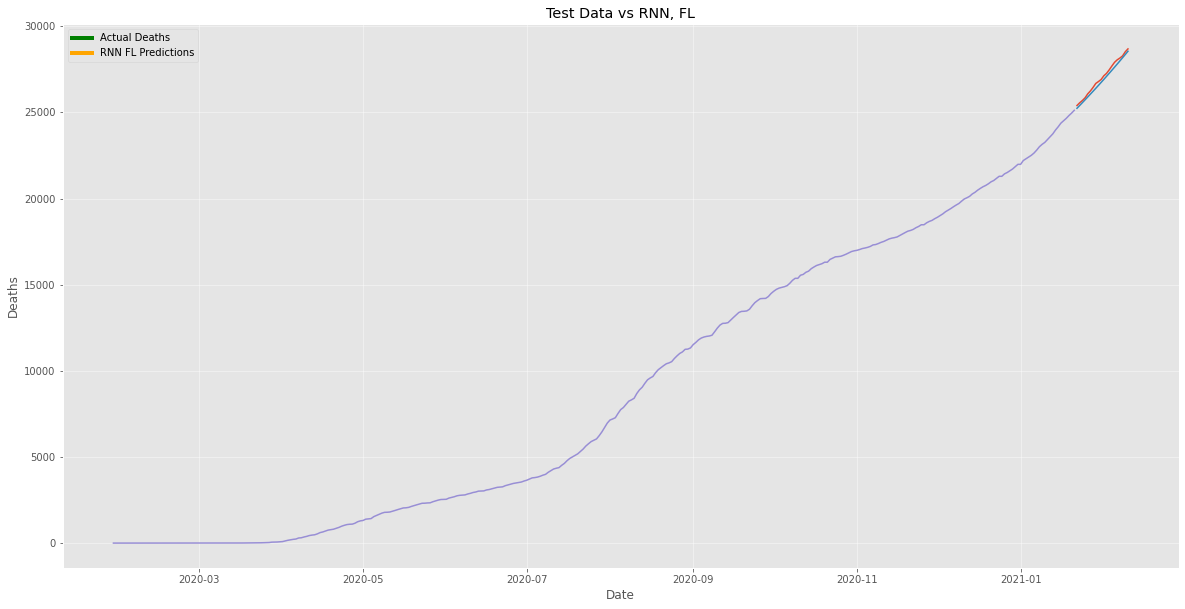

In [101]:
create_NN_predict(df_states,'FL',20,epochs=4)

### California

Epoch 1/4
304/304 [==============================] - 8s 22ms/step - loss: 0.0142
Epoch 2/4
304/304 [==============================] - 7s 22ms/step - loss: 5.4282e-04
Epoch 3/4
304/304 [==============================] - 7s 22ms/step - loss: 0.0015
Epoch 4/4
304/304 [==============================] - 7s 22ms/step - loss: 6.0757e-04


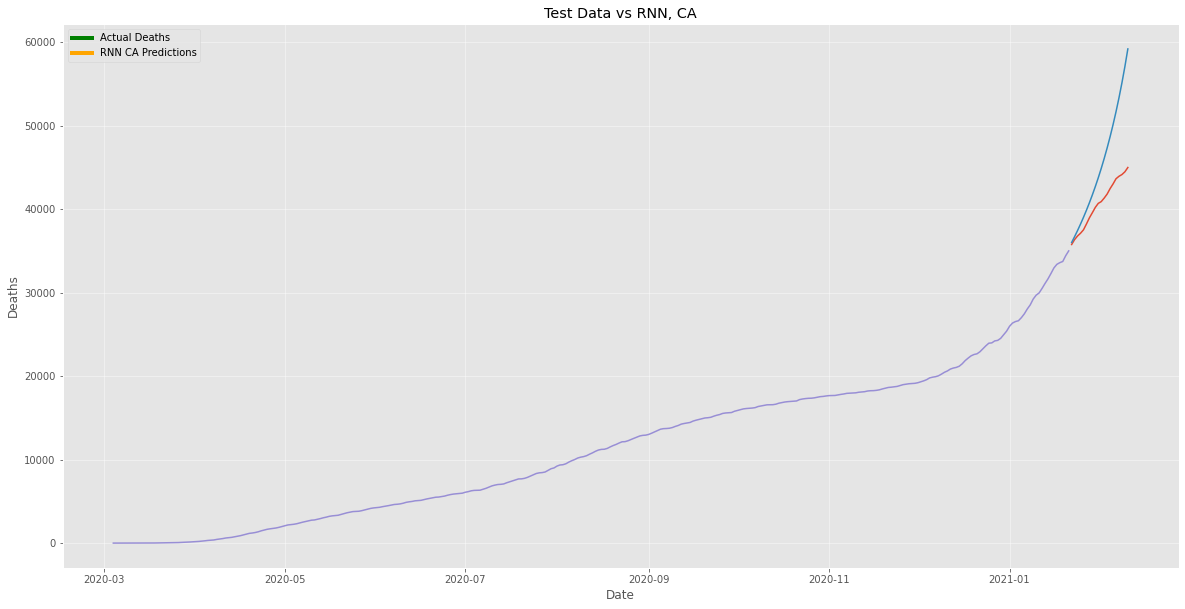

In [102]:
create_NN_predict(df_states,'CA',20,epochs=4)

## Multivariate Forecast with RNN

### Data Import and Ventilator/Death Plot

In [103]:
# initialize Df
df_whole_US = pd.read_csv('https://api.covidtracking.com/v1/us/daily.csv',index_col='date',parse_dates=True)

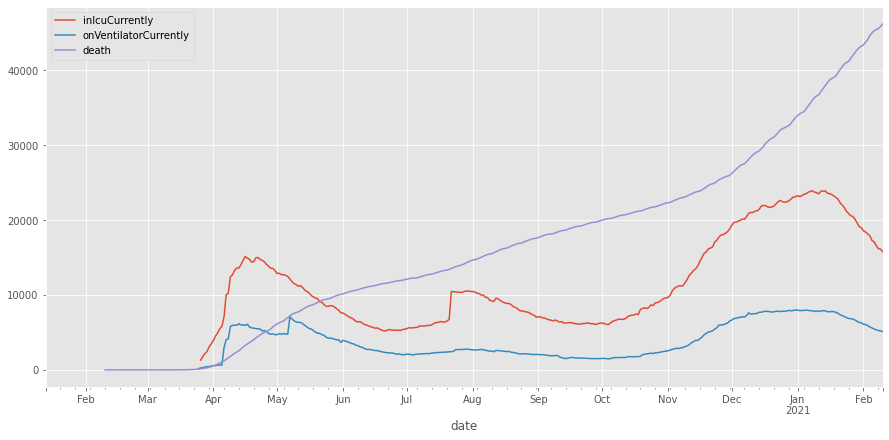

In [104]:
# we can see some lag here, common sense tells us we will probably see a 
#decrease in death rate after ICU and Ventilator populations fall. 
df_whole_US['inIcuCurrently'].plot(legend=True, figsize=(15,7))
df_whole_US['onVentilatorCurrently'].plot(legend=True, figsize=(15,7))
(df_whole_US['death']/10).plot(legend=True);  # to scale to other graphs

In [105]:
mv_forecast(df_whole_US,days_to_train=50,days_to_forecast=20,epochs=100) 
#hyperparameters to optimize days to train?

NameError: name 'mv_forecast' is not defined